1. Библиотеки

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
!pip install pytorch-pretrained-bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 60.5 MB/s eta 0:00:00


In [36]:
import sys
import numpy as np
import random as rn
import pandas as pd
import torch
from pytorch_pretrained_bert import BertModel
from torch import nn
from keras.utils import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import io
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

In [26]:
from google.colab import files
uploaded = files.upload()

Saving ratings_small.csv to ratings_small.csv


In [27]:
from google.colab import files
uploadedr = files.upload()

Saving movies_metadata.csv to movies_metadata.csv


In [44]:
import io
df = pd.read_csv(io.BytesIO(uploadedr['movies_metadata.csv']))
dfrating =  pd.read_csv(io.BytesIO(uploaded['ratings_small.csv']))
df.head()

<ipython-input-44-cc31223de175>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.BytesIO(uploadedr['movies_metadata.csv']))


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [45]:
dfrating.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [47]:
df = df.dropna(axis=0)
df.drop_duplicates(keep='first')
df.shape
df = df.drop(df.columns[[0, 1, 2,3,4,6,7,10,11,12,13,14,15,16,17,18,19,20,21,22,23]],axis = 1)
df["rating"] =dfrating["rating"].astype(int)

In [48]:
df

,id,original_title,overview,rating
9,710,GoldenEye,James Bond must unmask the mysterious head of ...,2
68,10634,Friday,Craig and Smokey are two guys in Los Angeles h...,4
69,755,From Dusk Till Dawn,Seth Gecko and his younger brother Richard are...,3
153,5894,Blue in the Face,"Auggie runs a small tobacco shop in Brooklyn, ...",3
178,9070,Mighty Morphin Power Rangers: The Movie,Power up with six incredible teens who out-man...,4
...,...,...,...,...
44274,281338,War for the Planet of the Apes,Caesar and his apes are forced into a deadly c...,3
44674,336890,Goon: Last of the Enforcers,"During a pro lockout, Doug ""The Thug"" Glatt is...",4
44821,10991,Pokémon 3: The Movie,When Molly Hale's sadness of her father's disa...,4
44842,335988,Transformers: The Last Knight,"Autobots and Decepticons are at war, with huma...",0


In [49]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, accuracy_score

 # TF-IDF

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()

X_train, X_test, y_train, y_test = train_test_split(df.overview, df.rating, test_size=0.2, random_state=42)
# Compute TF-IDF features for train set
X_train_tfidf = vectorizer.fit_transform(X_train)

# Train linear regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Compute TF-IDF features for test set and predict ratings
X_test_tfidf = vectorizer.transform(X_test)
predictions = model.predict(X_test_tfidf)

# Print predictions and test set ratings
for i in range(len(X_test)):
    print(f"Description: {X_test.tolist()[i]}")
    print(f"Predicted rating: {round(predictions[i], 2)}")
    print(f"Actual rating: {y_test.tolist()[i]}")

Description: In the world's most dangerous prison, a new game is born: Death Race. The rules of this adrenaline-fueled blood sport are simple, drive or die. When repentant convict Carl Lucas discovers there's a price on his head, his only hope is to survive a twisted race against an army of hardened criminals and tricked-out cars.
Predicted rating: 4
Actual rating: 4
Description: Jack Reacher must uncover the truth behind a major government conspiracy in order to clear his name. On the run as a fugitive from the law, Reacher uncovers a potential secret from his past that could change his life forever.
Predicted rating: 3
Actual rating: 4
Description: When Bella Swan moves to a small town in the Pacific Northwest to live with her father, she starts school and meets the reclusive Edward Cullen, a mysterious classmate who reveals himself to be a 108-year-old vampire. Despite Edward's repeated cautions, Bella can't help but fall in love with him, a fatal move that endangers her own life wh

In [ ]:
# Calculate the metrics
from math import sqrt
mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
f1 = f1_score(y_test, predictions.round(), average='weighted')
accuracy = accuracy_score(y_test, predictions.round())

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("F1 Score: ", f1)
print("Accuracy: ", accuracy)

MSE:  1.316546762589928
RMSE:  1.1474087164519573
MAE:  0.8273381294964028
F1 Score:  0.2787592482405054
Accuracy:  0.37410071942446044


# Bag of words

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, accuracy_score
from math import sqrt

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

# Transform the movie descriptions into Bag of Words vectors
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_data['overview'])
X_test = vectorizer.transform(test_data['overview'])

# Define the target variable
y_train = train_data['rating']
y_test = test_data['rating']

# Train the model using LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict the ratings on the test set
y_pred = model.predict(X_test)

# Calculate the metrics
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
f1 = f1_score(y_test, y_pred.round(), average='weighted')
accuracy = accuracy_score(y_test, y_pred.round())

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("F1 Score: ", f1)
print("Accuracy: ", accuracy)

MSE:  1.7841726618705036
RMSE:  1.3357292621899484
MAE:  0.9784172661870504
F1 Score:  0.27578021129163044
Accuracy:  0.3237410071942446


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# CNN

In [ ]:

# Split the data into training and testing sets
X = df['overview']
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the texts and pad the sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
maxlen = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=maxlen)

# Define the CNN model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=50, input_length=maxlen))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
model.fit(X, y_train, epochs=10, validation_split=0.2)


In [ ]:
from keras.models import Sequential,Model
from  keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense,GlobalMaxPooling1D,Dropout
from keras.preprocessing.text import Tokenizer


In [ ]:
max_vocab_size = 20000
max_sequence_length = 100
embedding_dim = 100
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(df['overview'])
sequences = tokenizer.texts_to_sequences(df['overview'])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Split data into train and test sets
train_ratio = 0.8
train_size = int(len(df) * train_ratio)
x_train = padded_sequences[:train_size]
y_train = df['rating'][:train_size].values
x_test = padded_sequences[train_size:]
y_test = df['rating'][train_size:].values

# Build model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(max_vocab_size, embedding_dim)(input_layer)
conv_layer = Conv1D(128, 5, activation='relu')(embedding_layer)
pooling_layer = MaxPooling1D(pool_size=2)(conv_layer)
flatten_layer = Flatten()(pooling_layer)
dense_layer = Dense(10, activation='relu')(flatten_layer)
output_layer = Dense(1, activation='linear')(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Train model
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
18/18 [==============================] - 6s 258ms/step - loss: 7.5838 - mae: 2.4026 - val_loss: 3.3802 - val_mae: 1.4618
Epoch 2/10
18/18 [==============================] - 2s 125ms/step - loss: 1.9272 - mae: 1.1233 - val_loss: 1.6011 - val_mae: 1.0489
Epoch 3/10
18/18 [==============================] - 3s 153ms/step - loss: 1.2025 - mae: 0.8466 - val_loss: 1.5127 - val_mae: 0.9954
Epoch 4/10
18/18 [==============================] - 2s 134ms/step - loss: 0.9739 - mae: 0.7622 - val_loss: 1.3548 - val_mae: 0.9132
Epoch 5/10
18/18 [==============================] - 2s 116ms/step - loss: 0.6359 - mae: 0.5922 - val_loss: 1.3458 - val_mae: 0.9163
Epoch 6/10
18/18 [==============================] - 3s 191ms/step - loss: 0.3824 - mae: 0.4234 - val_loss: 1.3581 - val_mae: 0.9282
Epoch 7/10
18/18 [==============================] - 1s 82ms/step - loss: 0.2141 - mae: 0.2938 - val_loss: 1.3313 - val_mae: 0.9199
Epoch 8/10
18/18 [==============================] - 1s 84ms/step - loss: 0.13

In [ ]:
y_pred = np.round(model.predict(x_test)).flatten()

f1 = f1_score(y_test, y_pred, average='weighted')
acc = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print('Test F1 score: {:.4f}'.format(f1))
print('Test Accuracy: {:.4f}'.format(acc))
print('Test MSE: {:.4f}'.format(mse))
print('Test RMSE: {:.4f}'.format(rmse))
print('Test MAE: {:.4f}'.format(mae))


5/5 [==============================] - 0s 3ms/step
Test F1 score: 0.2212
Test Accuracy: 0.3094
Test MSE: 1.5108
Test RMSE: 1.2291
Test MAE: 0.9353


# RNN

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error, mean_absolute_error


# Preprocessing
max_vocab_size = 20000
max_sequence_length = 100
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(df['overview'])
sequences = tokenizer.texts_to_sequences(df['overview'])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Split data into train and test sets
train_ratio = 0.8
train_size = int(len(df) * train_ratio)
x_train = padded_sequences[:train_size]
y_train = df['rating'][:train_size].values
x_test = padded_sequences[train_size:]
y_test = df['rating'][train_size:].values

# Build model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(max_vocab_size, embedding_dim)(input_layer)
lstm_layer = LSTM(128)(embedding_layer)
dense_layer = Dense(10, activation='relu')(lstm_layer)
output_layer = Dense(1, activation='linear')(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Train model
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

# Evaluate model
y_pred = np.round(model.predict(x_test)).flatten()

f1 = f1_score(y_test, y_pred, average='weighted')
acc = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print('Test F1 score: {:.4f}'.format(f1))
print('Test Accuracy: {:.4f}'.format(acc))
print('Test MSE: {:.4f}'.format(mse))
print('Test RMSE: {:.4f}'.format(rmse))
print('Test MAE: {:.4f}'.format(mae))

# Predict new ratings
new_descriptions = ['A captivating romantic drama', 'An action-packed thriller', 'A heartwarming family comedy']
new_sequences = tokenizer.texts_to_sequences(new_descriptions)
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length)
predictions = model.predict(new_padded_sequences)
print(predictions)

Epoch 1/10
18/18 [==============================] - 5s 148ms/step - loss: 7.6499 - mae: 2.3763 - val_loss: 1.2088 - val_mae: 0.8830
Epoch 2/10
18/18 [==============================] - 3s 147ms/step - loss: 1.4310 - mae: 0.9703 - val_loss: 1.2224 - val_mae: 0.8820
Epoch 3/10
18/18 [==============================] - 3s 149ms/step - loss: 1.2515 - mae: 0.8929 - val_loss: 1.2196 - val_mae: 0.8842
Epoch 4/10
18/18 [==============================] - 2s 125ms/step - loss: 1.2101 - mae: 0.8806 - val_loss: 1.2287 - val_mae: 0.8829
Epoch 5/10
18/18 [==============================] - 2s 90ms/step - loss: 1.1521 - mae: 0.8550 - val_loss: 1.2077 - val_mae: 0.8857
Epoch 6/10
18/18 [==============================] - 2s 94ms/step - loss: 1.0348 - mae: 0.8021 - val_loss: 1.2270 - val_mae: 0.8892
Epoch 7/10
18/18 [==============================] - 2s 89ms/step - loss: 0.8412 - mae: 0.6825 - val_loss: 1.2574 - val_mae: 0.8903
Epoch 8/10
18/18 [==============================] - 2s 89ms/step - loss: 0.5706

# BERT

In [40]:
# Install and import libraries
!pip install transformers

from transformers import BertTokenizer, AutoModel
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split, DataLoader
import matplotlib.pyplot as plt
import time
import datetime
from matplotlib.lines import Line2D
import warnings
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('fabriceyhc/bert-base-uncased-imdb', do_lower_case=True)

reviews=df['overview'].to_list()
ratings=df['rating'].to_list()
# A helper function used during training
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Loading BERT tokenizer...


In [51]:
# Lists containing BERT input data from the tokenizer
tokenized_reviews = []
attention_masks = []

# Loop through each review and tokeize
for review in reviews:

    # Encode the review using BERT tokenizer
    encoded_dict = tokenizer.encode_plus(
                        review,                      
                        truncation=True,
                        add_special_tokens = True, 
                        max_length = 512,          
                        pad_to_max_length = True,
                        return_attention_mask = True)
    
    # Append tokenized sentence   
    tokenized_reviews.append(encoded_dict['input_ids'])
    
    # Append the attention mask (padding locations within token set)
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors
tokenized_reviews = torch.tensor(tokenized_reviews)
attention_masks = torch.tensor(attention_masks)

# Convert targets list into tensor
labels = torch.tensor(ratings)
     

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [56]:
dataset = TensorDataset(tokenized_reviews, attention_masks, labels)

# Calculate the size of the data subsets (70-15-15 split for training, validation and testing sets)
train_size = int(0.7 * len(dataset))
val_size = int(0.5*(len(dataset) - train_size))
test_size = int(0.5*(len(dataset) - train_size))

# Generate subsets of the data using the above split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size,test_size])

In [57]:

# We will use a batch size of 16, as recommended by the creators of BERT
batch_size = 16

# Create training dataloader 
train_dataloader = DataLoader(
            train_dataset, 
            shuffle=True,
            batch_size = batch_size 
        )

# Create validation dataloader
validation_dataloader = DataLoader(
            val_dataset, 
            batch_size = batch_size 
        )

# Create testing dataloader
test_dataloader = DataLoader(
            test_dataset, 
            batch_size = batch_size 
        )
     

In [58]:
class RatingModel(nn.Module):
    def __init__(self):
        super(RatingModel, self).__init__()
        
        # Load pretrained BERT model
        self.base_model = AutoModel.from_pretrained('fabriceyhc/bert-base-uncased-imdb')
        # Include dropout layer in classification head
        self.dropout = nn.Dropout(0.5)
        # Add new output layer for classification
        self.linear = nn.Linear(768, 1) 
        
    def forward(self, tokenized_reviews, attn_mask):

        # Pass the tokenized reviews through the BERT model
        outputs = self.base_model(tokenized_reviews, attention_mask=attn_mask)
        outputs = self.dropout(outputs[0])

        # The slicing of the BERT model outputs (below) is to make use of the BERT output features 
        # from only the special [CLS] token for classification. This token is at index 0
        outputs = self.linear(outputs[:,0,:])
        
        return outputs

In [59]:
# Create new model
model = RatingModel()
model.cuda()

# Initialize loss function, optimizer and scheduler
# Mean Square Error loss for regression task
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

Some weights of the model checkpoint at fabriceyhc/bert-base-uncased-imdb were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [60]:
training_stats = []

# Training start time, to time training process
total_t0 = time.time()

# Training for 4 epochs, as is recommended for transfer learning by the BERT creators
num_epochs = 4

# Loop for each epoch. Will also validate each epoch
for epoch in range(num_epochs):
    # ========================================
    #               Training
    # ========================================

    print("")
    print(f'======== Epoch {epoch+1} / {4} ========')

    # Epoch start time for timing epoch length
    t0 = time.time()

    # Zero total epoch loss
    total_train_loss = 0

    # Set model back to train mode after validation
    model.train()

    # Loop through batches of training data
    for step, batch in enumerate(train_dataloader):

      # Progress update every 40 batches
      if step % 40 == 0 and not step == 0:

        # Calculate elapsed time in minutes
        elapsed = format_time(time.time()-t0)

        # Print batch number, time elapsed, and training loss of epoch so far
        print(f'  Batch {step}  of  {len(train_dataloader)}.    Elapsed: {elapsed}.    Training Loss: {total_train_loss/step}.')

      # Zero gradients for batch
      model.zero_grad()
      optimizer.zero_grad()

      # Load batch data
      b_tokenized_reviews = batch[0].cuda()
      b_input_mask = batch[1].cuda()
      # Regression model trained on scaled targets between 0-1, so must divide label by 10
      b_labels = batch[2].cuda()/10

      # Predict ratings
      preds=model(b_tokenized_reviews,b_input_mask)

      # Calculate batch loss
      loss = criterion(preds.squeeze().cuda(), b_labels)

      # Update epoch loss
      total_train_loss += loss.item()

      # Delete batch data for memory
      del b_tokenized_reviews,b_input_mask,b_labels

      # Compute gradients
      loss.float().backward()

      # Clip the norm of the gradients to 1.0 for exploding gradient
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Update model weights
      optimizer.step()

    # Update learning rate every epoch
    scheduler.step()

    # Save current model weights
    torch.save(model.state_dict(), f'imdb_{epoch}.pt')

    # Calculate the average loss over all batches
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    # Start time of validation
    t0 = time.time()

    # Put model in evaluation mode
    model.eval()

    # Tracking evaluation loss
    total_eval_loss = 0

    # Loop through all evaluation data in batches
    for step,batch in enumerate(validation_dataloader):

        b_tokenized_reviews = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_labels = batch[2].cuda()/10

        # Don't compute gradients during evaluation
        with torch.no_grad():
            preds=model(b_tokenized_reviews,b_input_mask).cuda()

        loss = criterion(preds.squeeze(), b_labels)

        del b_tokenized_reviews,b_input_mask,b_labels

        # Accumulate the validation loss
        total_eval_loss += loss.item()
        
    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Display the evaluation RMSE 
    print("  RMSE: {0:.2f}".format(avg_val_loss**0.5))

    # Measure how long the validation run took
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========

  Average training loss: 0.11
  Training epoch took: 0:00:45

Running Validation...
  RMSE: 0.16
  Validation Loss: 0.02
  Validation took: 0:00:03

======== Epoch 2 / 4 ========

  Average training loss: 0.04
  Training epoch took: 0:00:44

Running Validation...
  RMSE: 0.13
  Validation Loss: 0.02
  Validation took: 0:00:03

======== Epoch 3 / 4 ========

  Average training loss: 0.02
  Training epoch took: 0:00:45

Running Validation...
  RMSE: 0.14
  Validation Loss: 0.02
  Validation took: 0:00:03

======== Epoch 4 / 4 ========

  Average training loss: 0.02
  Training epoch took: 0:00:45

Running Validation...
  RMSE: 0.12
  Validation Loss: 0.01
  Validation took: 0:00:03

Training complete!
Total training took 0:03:12 (h:mm:ss)


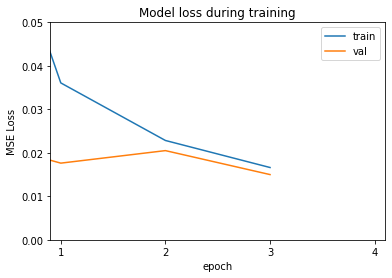

In [61]:
validation_loss=[]
training_loss=[]

for epoch in training_stats:
  validation_loss.append(epoch['Valid. Loss'])
  training_loss.append(epoch['Training Loss'])

# Display Losses
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Model loss during training')
plt.ylabel('MSE Loss')
plt.xlabel('epoch')
plt.xticks(ticks=[1,2,3,4])
plt.xlim((0.9,4.1))
plt.ylim((0,0.05))
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [62]:
print("")
print("Running Testing...")

# Start time of testing
t0 = time.time()

model.eval()

total_test_loss = 0

# Testing dictionary, to group predictions based on their target values
testing_stats={'0.1':[],'0.2':[],'0.3':[],'0.4':[],'0.5':[],'0.0':[]}

# Loop through all test data
for step,batch in enumerate(test_dataloader):

    b_tokenized_reviews = batch[0].cuda()
    b_input_mask = batch[1].cuda()
    b_labels = batch[2].cuda()/10

    with torch.no_grad():
        preds=model(b_tokenized_reviews,b_input_mask).cuda()

    # Update testing dictionary with new batch of predictions
    for pred,label in zip(preds,b_labels):
      testing_stats[str(round(label.item(),1))].append(pred)

    loss = criterion(preds.squeeze(), b_labels)

    del b_tokenized_reviews,b_input_mask,b_labels

    total_test_loss += loss.item()
    
avg_test_loss = total_test_loss / len(test_dataloader)

print("  RMSE: {0:.2f}".format(avg_test_loss**0.5))

testing_time = format_time(time.time() - t0)

print("  Test Loss: {0:.2f}".format(avg_test_loss))
print("  Test took: {:}".format(testing_time))



Running Testing...
  RMSE: 0.11
  Test Loss: 0.01
  Test took: 0:00:03


In [ ]:
print('Test MAE: {:.4f}'.format(mae))
print('Test F1 score: {:.4f}'.format(f1))
print('Test Accuracy: {:.4f}'.format(acc))

In [103]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 21.0 MB/s eta 0:00:00


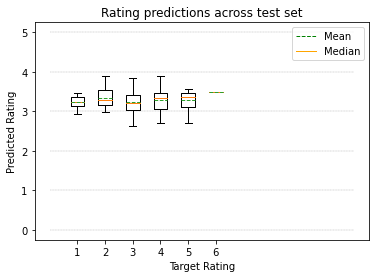

Test MSE: 12.1637
Test RMSE: 1.6545
Test MAE: 0.3488


In [121]:
warnings.filterwarnings('ignore')
import statistics
from torchmetrics import Accuracy
# Lists for scaled data, RMSE and size, with each element coming from a group of predictions from a given label
data=[]
rmse=[]
lengths=[]
acc = []
# Loop through each label group
for rating in testing_stats:
  # Scale data
  data.append(torch.tensor(testing_stats[rating]).cpu()*10)
  # Get size of prediction set
  lengths.append(len(data[-1]))
  # Calculate prediction error for set
  actual =torch.tensor(testing_stats[rating]).cpu()*10
  pred = float(rating)*10
  error=torch.tensor(testing_stats[rating]).cpu()*10-float(rating)*10
  # MSE for set
  mse=np.power(error,2).mean()
  # RMSE for set
  rmse.append(np.power(mse,0.5).item())
  # MAE for set
  mae =  mean_absolute_error(torch.tensor(testing_stats[rating]), torch.full_like(torch.tensor(testing_stats[rating]), float(rating)))

# Pl
# Plot bar graph
x=[0,1,2,3,4,5]
meanlineprops = dict(linestyle='--', linewidth=1)
flierprops = dict(marker='o', markerfacecolor='blue', markersize=1,markeredgecolor='none')
plt.yticks(ticks=x)
plt.hlines(x,0,11,linestyles='--',linewidth=0.3,color='grey')
plt.boxplot(data,meanline=True,showmeans=True,meanprops=meanlineprops,flierprops=flierprops)
plt.xlabel('Target Rating')
plt.ylabel('Predicted Rating')
plt.title('Rating predictions across test set')
legend_elements = [Line2D([0], [0], color='g',linestyle='--', lw=1, label='Median'),Line2D([0], [0], color='orange', lw=1, label='Mean')]
plt.legend(legend_elements,['Mean','Median','Outliers'])
plt.show()
print('Test MSE: {:.4f}'.format(mse))
print('Test RMSE: {:.4f}'.format(statistics.mean(rmse)))
print('Test MAE: {:.4f}'.format(mae))